The notebook is geared towards finding out patterns based on taxi-movement; in-other words, we looking at how people move in and out of Brookyln to see if there is a coorelation between taxi-movements and gentrification. We also further look at Incomes and and rents over 5 years (2010-2014)

In [133]:
import pandas as pd
import requests 
from io import StringIO
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
import plotly.plotly as py
import geopandas as gpd
from shapely import ops
from shapely import geometry as geom
import os
import urllib
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


We decided to take a  subset that is representative of our data; in doing so, we took  50,000 trips (the API end-point access 50,000 queries per instance) that were processed by *** VTS *** (vendor for Taxi Industry & helped to provided the data-set) with a *** Credit Card *** for the first instance and *** Cash *** for the second instance. We took 2 instance per any give year; hence, we have *** 500000 *** rows.

In [134]:
#YELLOW-TAXI 2014 DATA-SET EXPLORATION 
YTD_14_CC       ='https://data.cityofnewyork.us/resource/gkne-dk5s.json?vendor_id=VTS&payment_type=CRD&$limit=50000'
YTD_14_CSH      ='https://data.cityofnewyork.us/resource/gkne-dk5s.json?vendor_id=VTS&payment_type=CSH&$limit=50000'
raw_data_Y14CC  = pd.read_json(YTD_14_CC)   #50,000 rows
raw_data_Y14CS  = pd.read_json(YTD_14_CSH) #50,000 rows
raw_data_Y14    = raw_data_Y14CC.append(raw_data_Y14CS)
raw_data_Y14.shape #100,000

(100000, 17)

In [135]:
#GREEN-TAXI 2014 DATA-SET EXPLORATION 
GTD_14_CC       ='https://data.cityofnewyork.us/resource/7j25-xd5y.json?vendorid=2&payment_type=1&$limit=50000'
GTD_14_CSH      ='https://data.cityofnewyork.us/resource/7j25-xd5y.json?vendorid=2&payment_type=2&$limit=50000'
raw_data_G14CC  = pd.read_json(GTD_14_CC)   #50,000 rows
raw_data_G14CS  = pd.read_json(GTD_14_CSH) #50,000 rows
raw_data_G14    = raw_data_G14CC.append(raw_data_G14CS)
raw_data_G14.shape #100,000

(100000, 19)

The columns in the *Green taxi data-set* contains columns that are identical to the columns in yellow taxi data-set but with different column name; so we want to make sure that the column names are the same so that we can append the the two data frames

In [136]:

def match_col(list_df):
    for i in range(len(list_df)):
        for j in list_df[i].columns.values:
            if j == 'lpep_dropoff_datetime' or j == 'tpep_dropoff_datetime':
                list_df[i].rename(columns={j: 'dropoff_datetime' }, inplace=True)
            if j == 'lpep_pickup_datetime'   or j == 'tpep_pickup_datetime':
                list_df[i].rename(columns={j: 'pickup_datetime' }, inplace=True)
    return(list_df)


In [137]:
TD_14  = [raw_data_Y14,raw_data_G14]
match_col(TD_14)
Y_M_14 = TD_14[0]
G_M_14 = TD_14[1]
print("Columns for Green Taxi: ",G_M_14.columns.values)
#print()
print("Columns for Green Taxi: ",Y_M_14.columns.values)
Y_M_14.shape
G_M_14.shape

Columns for Green Taxi:  ['dropoff_latitude' 'dropoff_longitude' 'extra' 'fare_amount'
 'dropoff_datetime' 'pickup_datetime' 'mta_tax' 'passenger_count'
 'payment_type' 'pickup_latitude' 'pickup_longitude' 'ratecodeid'
 'store_and_fwd_flag' 'tip_amount' 'tolls_amount' 'total_amount'
 'trip_distance' 'trip_type' 'vendorid']
Columns for Green Taxi:  ['dropoff_datetime' 'dropoff_latitude' 'dropoff_longitude' 'fare_amount'
 'imp_surcharge' 'mta_tax' 'passenger_count' 'payment_type'
 'pickup_datetime' 'pickup_latitude' 'pickup_longitude' 'rate_code'
 'tip_amount' 'tolls_amount' 'total_amount' 'trip_distance' 'vendor_id']


(100000, 19)

We refined the data-sets so that it only contain the columns we need and would make append possible because now both data set would have same size after to being processed.

In [138]:
def needed_col(data):
    cols_y = ['dropoff_latitude', 'dropoff_longitude','dropoff_datetime' , 'pickup_datetime',
              'pickup_latitude','pickup_longitude','tip_amount','trip_distance']
    refine_data = pd.DataFrame(data, columns = cols_y)
    return (refine_data)

Processed_YTD = needed_col(Y_M_14)
processed_GTD = needed_col(G_M_14)
Taxi_Data_14  = Processed_YTD.append(processed_GTD)
Taxi_Data_14.shape #(200000, 8) 

(200000, 8)

In [139]:
zipgeojson = "https://github.com/YuHuaCheng/Map/raw/master/data/nyc-zip-code-tabulation-areas-polygons.geojson"
#zipgeojson = "https://github.com/dwillis/nyc-maps/raw/master/boroughs.geojson"
zipsfile = os.path.join("data",zipgeojson.split("/")[-1])

try:
    NZ = gpd.read_file(zipsfile)
except OSError as e:
    urllib.request.urlretrieve(zipgeojson, zipsfile)
    
    #zips geojson had a var assignment that caused problems
    fin      = open(zipsfile)
    
    lines    = [line for line in fin]
    lines[0] = lines[0].replace("var nycdata = ", "")
    
    fin.close()
    
    fout = open(zipsfile, "w")
    for line in lines:
        fout.write(line)
    fout.flush()
    fout.close()
    
    NZ = gpd.read_file(zipsfile)
NZ.shape

(262, 12)

Below is the Geography of NYC 

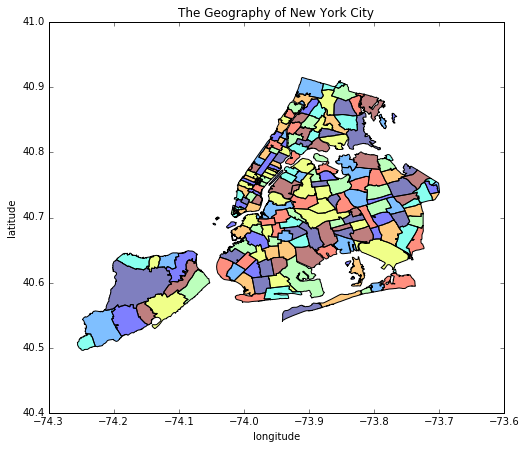

In [140]:
#Making Sure that Neighborhood geoJason is indeed that of New York City
NZ.plot(figsize=(14,7))
plt.title("The Geography of New York City")
plt.xlabel("longitude")
plt.ylabel("latitude")

In [141]:
BK = NZ[NZ.CTY_FIPS == '047']
BK = BK.reset_index()
BK.geometry.shape

(40,)

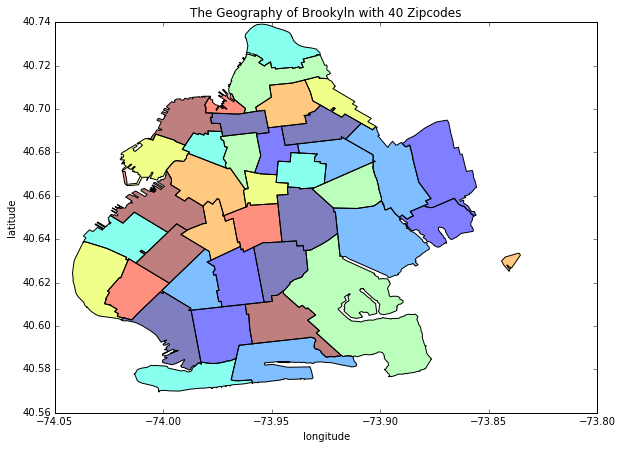

In [142]:
BK.plot(figsize=(14,7))
plt.title("The Geography of Brookyln with 40 Zipcodes")
plt.xlabel("longitude")
plt.ylabel("latitude")

In [143]:
def cov_latlon_POINT(dataframe):
    pickup_latlon = []
    for i in range (len(dataframe)):
        pickup_latlon.append(geom.Point(dataframe.pickup_longitude.iloc[i],
                                        dataframe.pickup_latitude.iloc[i]))
    PickupP_df      = gpd.GeoSeries(pickup_latlon)
    PickupP_df      = PickupP_df[PickupP_df.values != 'POINT (0.0 0.0)'] #get rid of 0.0 0.0 lon-lat Points
    GeoPickup_Point = gpd.GeoDataFrame(geometry=PickupP_df)
    #GeoPickup_Point['index'] = GeoPickup_Point.index
    return (GeoPickup_Point)
GeoPickup_BK        = cov_latlon_POINT(Taxi_Data_14)
print(GeoPickup_BK.shape)
GeoPickup_BK.head()

(200000, 1)


,geometry
0,POINT (-74.003045 40.75017)
1,POINT (-73.95495699999999 40.765297)
2,POINT (-73.995363 40.760205)
3,POINT (-73.93031000000001 40.801725)
4,POINT (-74.000792 40.731855)


Convert longitude and Latitude to points

In [144]:
def cov_latlon_dropoff_POINT(dataframe):
    dropoff_latlon = []
    for i in range (len(dataframe)):
        dropoff_latlon.append(geom.Point(dataframe.dropoff_longitude.iloc[i],
                                        dataframe.dropoff_latitude.iloc[i]))
    DropoffP_df      = gpd.GeoSeries(dropoff_latlon)
    DropoffP_df      = DropoffP_df[DropoffP_df.values != 'POINT (0.0 0.0)'] #get rid of 0.0 0.0 lon-lat Points
    GeoDropoff_Point = gpd.GeoDataFrame(geometry=DropoffP_df)
    #GeoDropoff_Point['index'] = GeoDropoff_Point.index
    return (GeoDropoff_Point)
GeoDropoff_BK        = cov_latlon_dropoff_POINT(Taxi_Data_14)
print(GeoDropoff_BK.shape)
GeoDropoff_BK.head()

(200000, 1)


,geometry
0,POINT (-73.974042 40.789107)
1,POINT (-73.97743 40.757927)
2,POINT (-73.97880000000001 40.76715)
3,POINT (-73.987685 40.758083)
4,POINT (-74.007797 40.73701)


In [145]:
Back_Forth_BK = GeoPickup_BK.append(GeoDropoff_BK) 

Filter only Brookyln Points

In [146]:
def City_only_Points(GeoP):
    COP = []
    for i in range(len(BK)):
        Zip_idx = GeoP[GeoP.geometry.within(BK.geometry[i])]
        COP.append(Zip_idx)
    return(COP)


In [147]:
BK_only = City_only_Points(Back_Forth_BK )

In [148]:
sum_  = 0
for i in range (len(BK_only)):
    sum_ = sum_ + len(BK_only[i])
print("Total number of Trips in BK out of 200,000 Trips for Year 2014: ", sum_)

Total number of Trips in BK out of 200,000 Trips for Year 2014:  66825


Based on our subset of size 200,000, Brooklyn accounts For *** 33.4% *** of all Yellow-Green taxi trips that happened in 2014 

In [149]:
#get the Zip Code and the # of trips in that Zipcode
BK_per_Zip = {}
for i in range(len(BK_only)):
    BK_per_Zip[i] = len(BK_only[i])

In [150]:
col = ['Number of Trips']

In [151]:
BK_per_Zip_df = pd.DataFrame.from_dict(BK_per_Zip, orient='index')

In [152]:
BK_per_Zip_df.rename(columns={0: "Num Trips per Zip in BK"}, inplace = True)

In [153]:
BK_per_Zip_df['ZIP'] = BK.postalCode.values

In [154]:
BK_per_Zip_df.head()

,Num Trips per Zip in BK,ZIP
0,1748,11221
1,2800,11216
2,922,11233
3,797,11213
4,227,11212


In [155]:
max_trip = BK_per_Zip_df.sort_values('Num Trips per Zip in BK', ascending = False)
max_trip.head()

,Num Trips per Zip in BK,ZIP
13,14527,11211
17,10644,11201
21,5433,11217
12,4893,11222
24,4518,11215


In [156]:
max_val = max_trip.reset_index()
print ("The max trips made per is Zip-Code is: ", max_val.loc[0]['Num Trips per Zip in BK'])
print ("The ZipCode that it Corresponds to is: ", max_val.loc[0].ZIP)

The max trips made per is Zip-Code is:  14527
The ZipCode that it Corresponds to is:  11211


From a Subset of *200,000* trips, Brooklyn exprienced ** 66,825 ** trips; and out of that, the most trips made were @ Zip Code: *** 11211 (Williamsburg, Brookyln) *** and the number of trips made are : *** 14,527 *** which is *** 22% *** all trips made in Brookyln. We would see how that compares to previous years (2013-2010). Coming in second is Zip Code: ***11201 (Brookyln Heights, Brookyln) *** with ***10,644 *** trips and that's ***16%*** of all trips made in Brookyln.

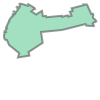

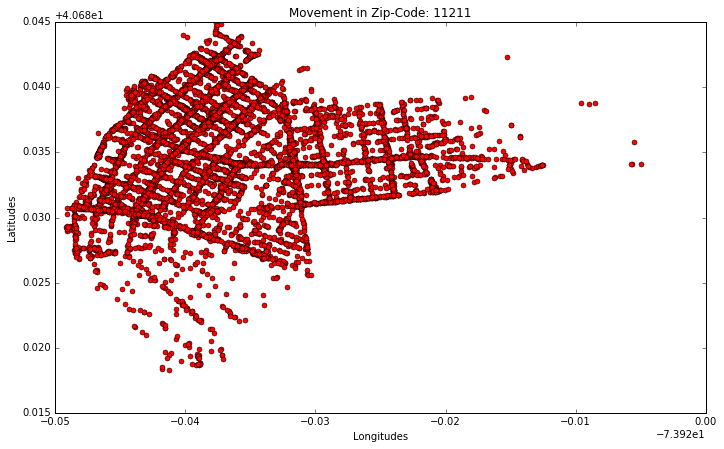

In [157]:
Plot_11211_14 = Back_Forth_BK [Back_Forth_BK .geometry.within(BK.geometry[13])]
BK.geometry[13]
Plot_11211_14.plot(marker='o', color='red', markersize=5, figsize=(14,7))
plt.title("Movement in Zip-Code: " + str(BK.postalCode.iloc[13]))
plt.xlabel("Longitudes")
plt.ylabel("Latitudes")
BK.geometry[13]

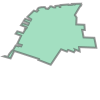

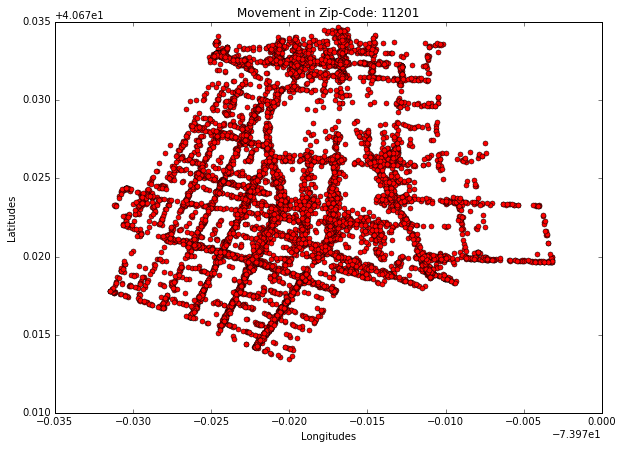

In [158]:
Plot_11201_14 = Back_Forth_BK [Back_Forth_BK .geometry.within(BK.geometry[17])]
BK.geometry[17]
Plot_11201_14.plot(marker='o', color='red', markersize=5, figsize=(14,7))
plt.title("Movement in Zip-Code: " + str(BK.postalCode.iloc[17]))
plt.xlabel("Longitudes")
plt.ylabel("Latitudes")
BK.geometry[17]

In [159]:
Plot_11211_14.head()

,geometry
165,POINT (-73.95090999999999 40.710997)
448,POINT (-73.958223 40.721612)
469,POINT (-73.944242 40.71164)
482,POINT (-73.95441 40.7107)
643,POINT (-73.952192 40.718117)


In [160]:
#using the points for Zip 11211 to other datapoints that are associated with it
Plot_11211_14.index

Int64Index([   165,    448,    469,    482,    643,    981,   1282,   1452,
              1491,   1659,
            ...
            199781, 199783, 199791, 199833, 199855, 199856, 199896, 199929,
            199941, 199967],
           dtype='int64', length=14527)

In [161]:
array_idx = np.array(Plot_11211_14.index)
array_idxh = np.array(Plot_11201_14.index)

In [162]:
williB    = Taxi_Data_14.iloc[array_idx]
BkHeight = Taxi_Data_14.iloc[array_idxh]

In [163]:
williB.head()

,dropoff_latitude,dropoff_longitude,dropoff_datetime,pickup_datetime,pickup_latitude,pickup_longitude,tip_amount,trip_distance
165,40.726490,-73.952262,2014-04-24T10:58:00.000,2014-04-24T10:53:00.000,40.710997,-73.950910,2.00,1.30
448,40.775342,-73.980107,2014-04-12T02:39:00.000,2014-04-12T02:11:00.000,40.721612,-73.958223,5.40,7.88
469,40.742997,-74.000117,2014-01-26T04:33:00.000,2014-01-26T04:15:00.000,40.711640,-73.944242,3.70,4.97
482,40.714610,-73.991360,2014-06-08T12:30:00.000,2014-06-08T12:17:00.000,40.710700,-73.954410,2.30,2.48
643,40.690312,-73.981735,2014-07-20T01:19:00.000,2014-07-20T01:10:00.000,40.718117,-73.952192,3.25,3.67


In [164]:
avg_tip_williB = williB.tip_amount[:].mean()
avg_tip_BkHeight = BkHeight.tip_amount[:].mean()

In [165]:
print(avg_tip_williB)
print(avg_tip_BkHeight)

1.7115791285193078
1.7309357384441957


In [166]:
williB.dropoff_datetime = williB.dropoff_datetime.astype("datetime64")
BkHeight.dropoff_datetime = BkHeight.dropoff_datetime.astype("datetime64")

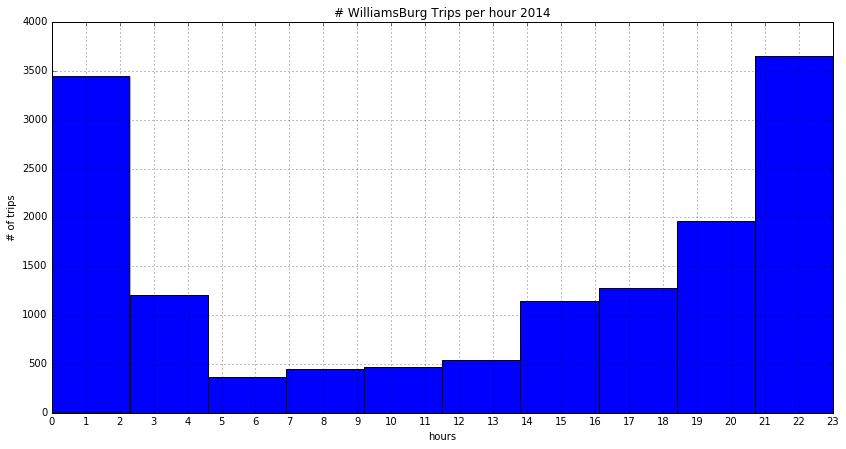

In [167]:
plt.figure(figsize=(14,7))
plt.hist(williB.dropoff_datetime.dt.hour)
plt.title('# WilliamsBurg Trips per hour 2014')
plt.xlabel('hours')
plt.ylabel('# of trips')
plt.grid(True)
plt.xticks(range(24))
plt.xlim(0.0,23)
plt.show()

In 2014,Most trips were to or made form WalliamsBurg (11211) within ***8:45 pm (20.45 hours)*** to ***2:15 am (2.15 hours)***

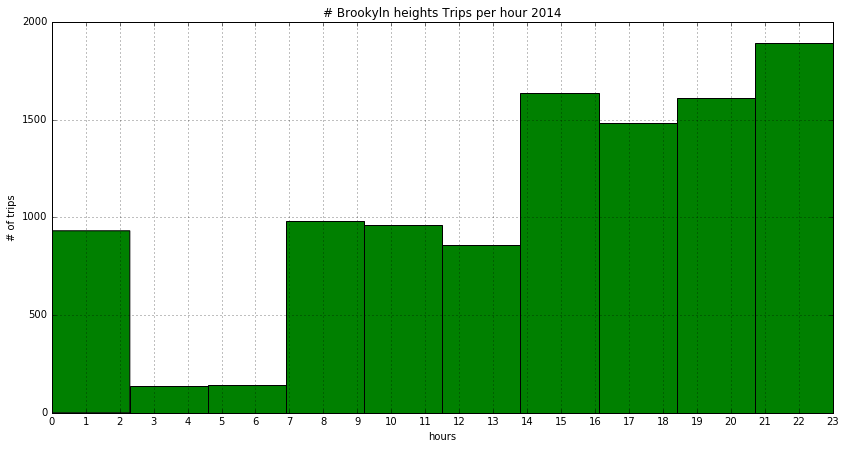

In [168]:
plt.figure(figsize=(14,7))
plt.hist(BkHeight.dropoff_datetime.dt.hour, color = 'g')
plt.title('# Brookyln heights Trips per hour 2014')
plt.xlabel('hours')
plt.ylabel('# of trips')
plt.grid(True)
plt.xticks(range(24))
plt.xlim(0.0,23)
plt.show()

In 2014,Most trips were made to or made form Brookyln-Heights (11201) within ***1:45 pm (13.45 hours)*** to ***23:00 pm (23.00 hours)***

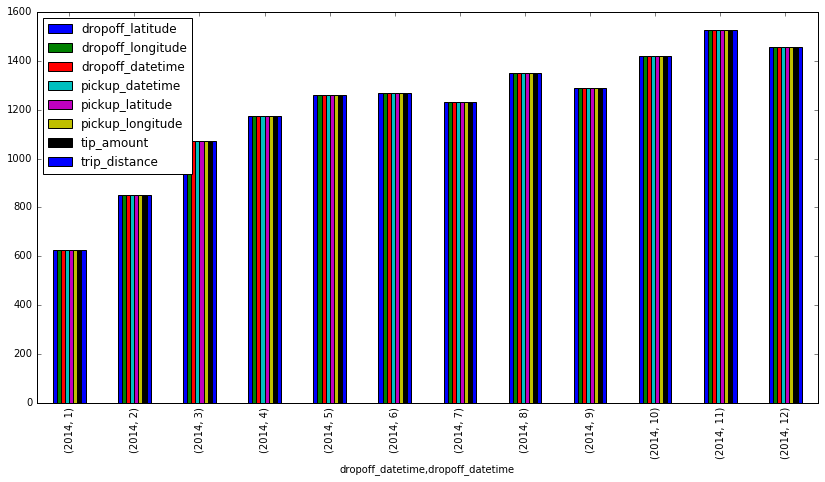

In [169]:
williB.groupby([williB.dropoff_datetime.dt.year, williB.dropoff_datetime.dt.month]).count().plot(kind="bar", figsize=(14,7))

The highest trip in WilliamBurg is in **November** followed by **December** 

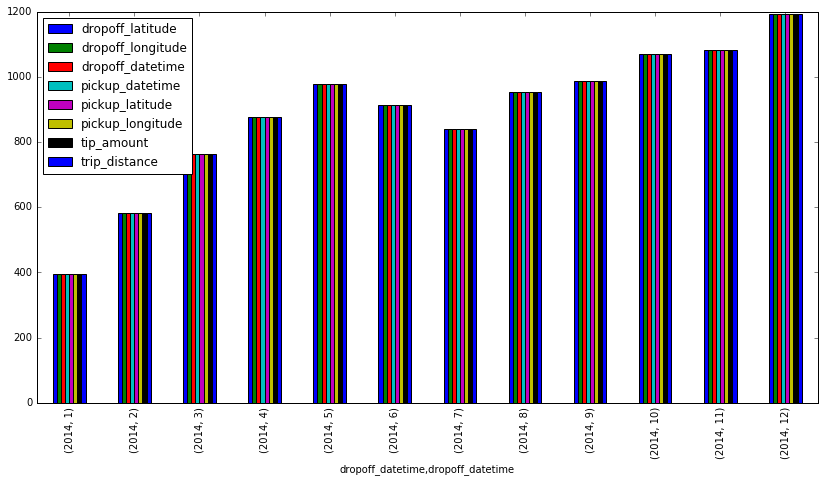

In [170]:
BkHeight.groupby([BkHeight.dropoff_datetime.dt.year, BkHeight.dropoff_datetime.dt.month]).count().plot(kind="bar", figsize=(14,7))

The highest trip in Brookyln-Heights is in **December** followed by **November** 

### SUMMARY
In 2014, *22%* of all trips made in Brookyln were made in or from Williamsburg  and those trips happened from *8:45 pm (20.45 hours) to 2:15 am (2.15 hours).* The most travel period to or from WilliamsBurg is in November. In Second is Brookyln-Heights with *16%* of all trips made in Brooklyn from *1:45 pm (13.45 hours) to 23:00 pm (23.00 hours)* and most of those trips happened in *December.* Therefore we would observed this stats over 4 years back and see if its consistent.

In [171]:
#YELLOW-TAXI 2013 DATA-SET EXPLORATION 
YTD_13_CC       = 'https://data.cityofnewyork.us/resource/t7ny-aygi.json?vendorid=VTS&payment_type=CRD&$limit=50000'
YTD_13_CSH      = 'https://data.cityofnewyork.us/resource/t7ny-aygi.json?vendorid=VTS&payment_type=CSH&$limit=50000'
raw_data_Y13CC  = pd.read_json(YTD_13_CC)   #50,000 rows
raw_data_Y13CS  = pd.read_json(YTD_13_CSH) #50,000 rows
raw_data_Y13    = raw_data_Y13CC.append(raw_data_Y13CS)
raw_data_Y13.shape #100,000

(100000, 19)

In [172]:
#GREEN-TAXI 2013 DATA-SET EXPLORATION 
GTD_13_CC       ='https://data.cityofnewyork.us/resource/h4pe-ymjc.json?vendorid=2&payment_type=1&$limit=50000'
GTD_13_CSH      ='https://data.cityofnewyork.us/resource/h4pe-ymjc.json?vendorid=2&payment_type=2&$limit=50000'
raw_data_G13CC  = pd.read_json(GTD_13_CC)   #50,000 rows
raw_data_G13CS  = pd.read_json(GTD_13_CSH) #50,000 rows
raw_data_G13    = raw_data_G13CC.append(raw_data_G13CS)
raw_data_G13.shape #100,000

(100000, 19)

In [173]:
TD_13 = [raw_data_Y13,raw_data_G13]
match_col(TD_13)
Y_M_13 = TD_13[0]
G_M_13 = TD_13[1]
Processed_YTD_13 = needed_col(Y_M_13)
processed_GTD_13 = needed_col(G_M_13)
Taxi_Data_13  = Processed_YTD_13.append(processed_GTD_13)
Taxi_Data_13.shape

(200000, 8)

In [174]:
GeoPickup_BK_13  = cov_latlon_POINT(Taxi_Data_13)
GeoDropoff_BK_13 = cov_latlon_dropoff_POINT(Taxi_Data_13)
Back_Forth_BK_13 = GeoPickup_BK_13.append(GeoDropoff_BK_13)
print(Back_Forth_BK_13.shape)
Back_Forth_BK_13.head()

(400000, 1)


,geometry
0,POINT (-73.964572 40.764975)
1,POINT (-73.974712 40.742012)
2,POINT (-73.984155 40.729117)
3,POINT (-73.968048 40.762497)
4,POINT (-74.004397 40.70776)


In [175]:
BK_only_13 = City_only_Points(Back_Forth_BK_13)

In [176]:
sum_  = 0
for i in range (len(BK_only_13)):
    sum_ = sum_ + len(BK_only_13[i])
print("Total number of Trips in BK out of 200,000 Trips for Year 2013: ", sum_)

Total number of Trips in BK out of 200,000 Trips for Year 2013:  37881


In [177]:
BK_per_Zip_13 = {}
for i in range(len(BK_only_13)):
    BK_per_Zip_13[i] = len(BK_only_13[i])

In [178]:
BK_per_Zip_df_13 = pd.DataFrame.from_dict(BK_per_Zip_13, orient='index')

In [179]:
BK_per_Zip_df_13.rename(columns={0: "Num_Trips_per_Zip_in_BK_2013"}, inplace = True)
BK_per_Zip_df_13['ZIP'] = BK.postalCode.values
BK_per_Zip_df_13.head()

,Num_Trips_per_Zip_in_BK_2013,ZIP
0,792,11221
1,1034,11216
2,295,11233
3,221,11213
4,66,11212


In [180]:
max_trip = BK_per_Zip_df_13.sort_values("Num_Trips_per_Zip_in_BK_2013", ascending = False)
max_trip.head()

,Num_Trips_per_Zip_in_BK_2013,ZIP
13,11087,11211
17,6133,11201
12,3479,11222
21,2930,11217
24,1948,11215


In [181]:
max_val = max_trip.reset_index()
print ("The max trips made per is Zip-Code is: ", max_val.loc[0]['Num_Trips_per_Zip_in_BK_2013'])
print ("The ZipCode that it Corresponds to is: ", max_val.loc[0].ZIP)

The max trips made per is Zip-Code is:  11087
The ZipCode that it Corresponds to is:  11211


From a Subset of *200,000* trips, Brooklyn exprienced ** 37,881 ** trips; and out of that, the most trips made were @ Zip Code: *** 11211 (Williamsburg, Brookyln) *** and the number of trips made are : *** 11,087 *** which is *** 29% *** all trips made in Brookyln. We would see how that compares to previous years (2012-2010). Coming in second is Zip Code: ***11201 (Brookyln Heights, Brookyln) *** with ***6,133*** trips and that's ***16%*** of all trips made in Brookyln.

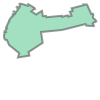

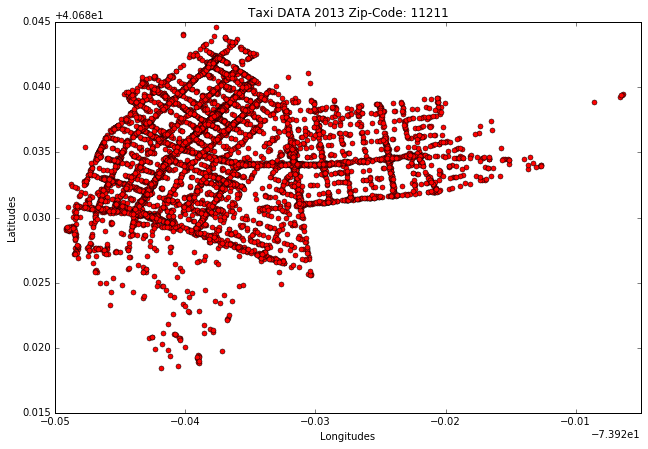

In [182]:
Plot_11211_13 = Back_Forth_BK_13[Back_Forth_BK_13.geometry.within(BK.geometry[13])]
#BK.geometry[13]
Plot_11211_13.plot(marker='o', color='red', markersize=5, figsize=(14,7))
plt.title("Taxi DATA 2013 Zip-Code: " + str(BK.postalCode.iloc[13]))
plt.xlabel("Longitudes")
plt.ylabel("Latitudes")
BK.geometry[13]

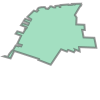

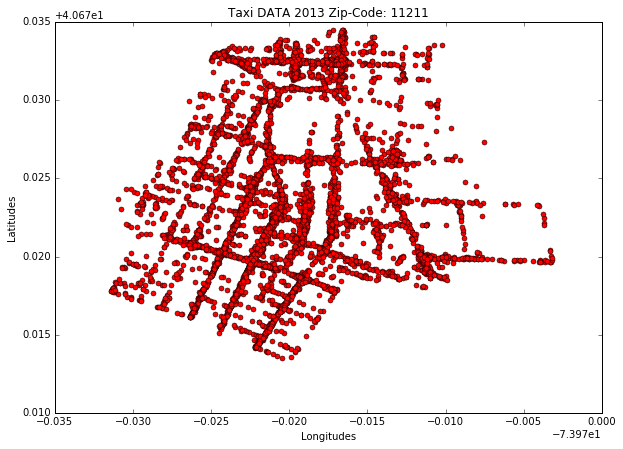

In [183]:
Plot_11201_13 = Back_Forth_BK_13[Back_Forth_BK_13.geometry.within(BK.geometry[17])]
#BK.geometry[13]
Plot_11201_13.plot(marker='o', color='red', markersize=5, figsize=(14,7))
plt.title("Taxi DATA 2013 Zip-Code: " + str(BK.postalCode.iloc[13]))
plt.xlabel("Longitudes")
plt.ylabel("Latitudes")
BK.geometry[17]

In [184]:
array_idx1 = np.array(Plot_11211_13.index)
array_idxh1 = np.array(Plot_11201_13.index)

In [185]:
williB_13   = Taxi_Data_13.iloc[array_idx1]
BkHeight_13 = Taxi_Data_13.iloc[array_idxh1]
williB_13.head()

,dropoff_latitude,dropoff_longitude,dropoff_datetime,pickup_datetime,pickup_latitude,pickup_longitude,tip_amount,trip_distance
44,40.714652,-73.942067,2013-07-17T23:01:00.000,2013-07-17T22:52:00.000,40.717167,-73.958403,2.12,1.51
116,40.696377,-73.971472,2013-05-27T21:50:00.000,2013-05-27T21:34:00.000,40.720787,-73.956568,2.70,2.74
287,40.741652,-74.000867,2013-01-03T23:05:00.000,2013-01-03T22:45:00.000,40.717535,-73.958077,2.50,4.75
453,40.760633,-73.994892,2013-01-20T02:49:00.000,2013-01-20T02:32:00.000,40.710982,-73.951270,4.20,6.60
458,40.717567,-73.958007,2013-08-23T22:07:00.000,2013-08-23T22:00:00.000,40.714230,-73.947350,0.00,1.33


In [186]:
avg_tip_williB_13   = williB_13.tip_amount[:].mean()
avg_tip_BkHeight_13 = BkHeight_13.tip_amount[:].mean()
print(avg_tip_williB_13)
print(avg_tip_BkHeight_13)

1.7882258500947121
1.9332887656937872


In [187]:
williB_13.dropoff_datetime   = williB_13.dropoff_datetime.astype("datetime64")
BkHeight_13.dropoff_datetime = BkHeight_13.dropoff_datetime.astype("datetime64")

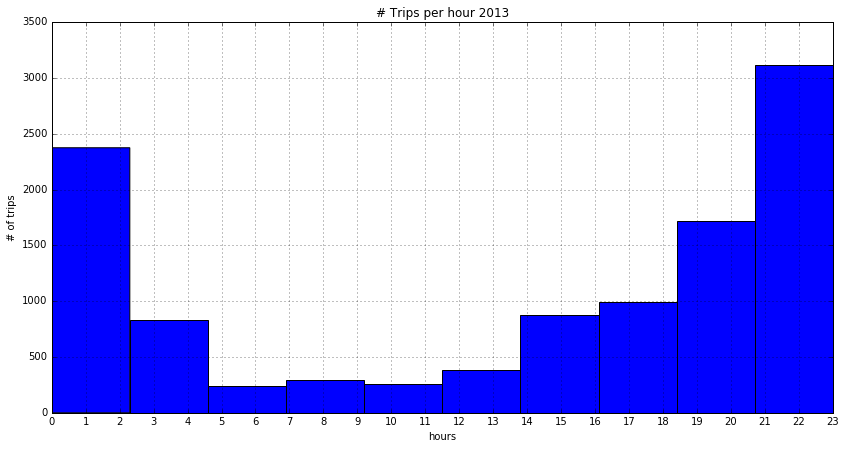

In [188]:
plt.figure(figsize=(14,7))
plt.hist(williB_13.dropoff_datetime.dt.hour)
plt.title('# Trips per hour 2013')
plt.xlabel('hours')
plt.ylabel('# of trips')
plt.grid(True)
plt.xticks(range(24))
plt.xlim(0.0,23)
plt.show()

Similary just like 2014,most trips made in 2013 were to or form WalliamsBurg (11211) within ***8:45 pm (20.45 hours)*** to ***2:15 am (2.15 hours)*** with *0.00 hours - 2.15 hours* having few hours compared to 2014

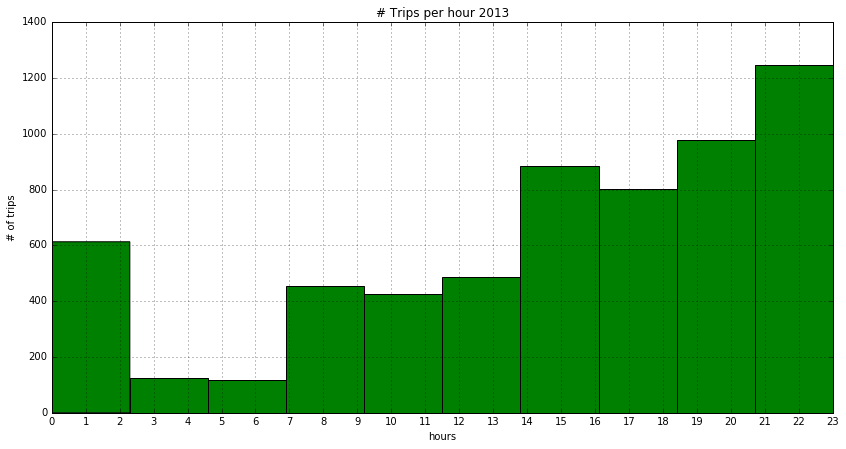

In [189]:
plt.figure(figsize=(14,7))
plt.hist(BkHeight_13.dropoff_datetime.dt.hour, color = 'g')
plt.title('# Trips per hour 2013')
plt.xlabel('hours')
plt.ylabel('# of trips')
plt.grid(True)
plt.xticks(range(24))
plt.xlim(0.0,23)
plt.show()

Just like in 2014, most trips were made to or made form Brookyln-Heights (11201) within 1:45 pm (13.45 hours) to 23:00 pm (23.00 hours)

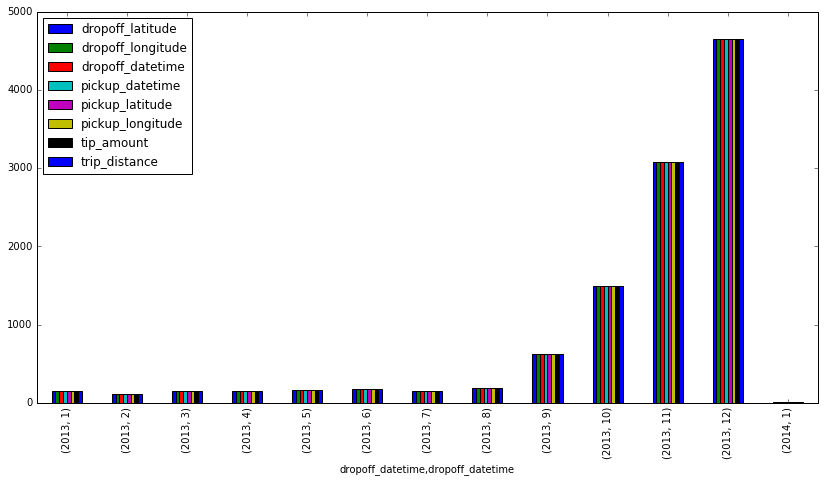

In [190]:
williB_13.groupby([williB_13.dropoff_datetime.dt.year, williB_13.dropoff_datetime.dt.month]).count().plot(kind="bar",figsize=(14,7))

In 2013 most trips in WilliamsBurg were made in December which is different from 2014 and also there way less trips made in another months compared to 2014.

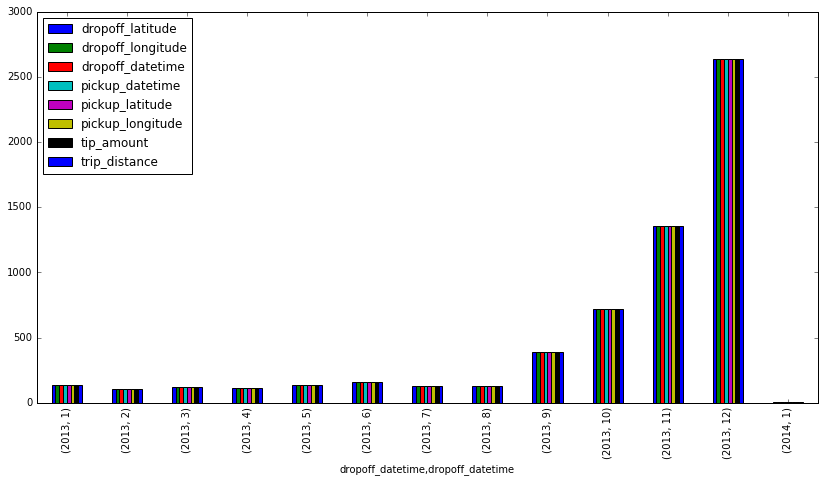

In [191]:
BkHeight_13.groupby([BkHeight_13.dropoff_datetime.dt.year, BkHeight_13.dropoff_datetime.dt.month]).count().plot(kind="bar",figsize=(14,7))

The highest trip in Brookyln-Heights is in **December** followed by **November** and this pretty consistent with 2014

In [192]:
YTD_12_CC       = 'https://data.cityofnewyork.us/resource/kerk-3eby.json?vendorid=VTS&payment_type=CRD&$limit=50000'
YTD_12_CSH      = 'https://data.cityofnewyork.us/resource/kerk-3eby.json?vendorid=VTS&payment_type=CSH&$limit=50000'
raw_data_Y12CC  = pd.read_json(YTD_12_CC)   #50,000 rows
raw_data_Y12CS  = pd.read_json(YTD_12_CSH) #50,000 rows
raw_data_Y12    = raw_data_Y12CC.append(raw_data_Y12CS)
raw_data_Y12.shape #100,000


(100000, 19)

In [193]:
def match_col_l1(list_df):
    for j in list_df.columns.values:
        if j == 'lpep_dropoff_datetime' or j == 'tpep_dropoff_datetime':
            list_df.rename(columns={j: 'dropoff_datetime' }, inplace=True)
        if j == 'lpep_pickup_datetime'   or j == 'tpep_pickup_datetime':
            list_df.rename(columns={j: 'pickup_datetime' }, inplace=True)
    return(list_df)

In [194]:
raw_data_Y12.head()

,dropoff_latitude,dropoff_location,dropoff_longitude,extra,fare_amount,mta_tax,passenger_count,payment_type,pickup_latitude,pickup_location,pickup_longitude,ratecodeid,tip_amount,tolls_amount,total_amount,tpep_dropoff_datetime,tpep_pickup_datetime,trip_distance,vendorid
0,40.749175,"{'type': 'Point', 'coordinates': [-73.972132, ...",-73.972132,1.0,23.0,0.5,6,CRD,40.746992,"{'type': 'Point', 'coordinates': [-73.892175, ...",-73.892175,1,4.00,4.8,33.30,2012-10-11T18:02:00.000,2012-10-11T17:34:00.000,5.79,VTS
1,40.807905,"{'type': 'Point', 'coordinates': [-73.949388, ...",-73.949388,0.0,52.0,0.5,1,CRD,40.644622,"{'type': 'Point', 'coordinates': [-73.782115, ...",-73.782115,2,10.40,4.8,67.70,2012-12-13T00:02:00.000,2012-12-12T23:38:00.000,18.36,VTS
2,40.775685,"{'type': 'Point', 'coordinates': [-73.927845, ...",-73.927845,1.0,25.3,0.5,1,CRD,40.742590,"{'type': 'Point', 'coordinates': [-73.993078, ...",-73.993078,1,5.26,4.8,36.86,2012-06-26T20:04:00.000,2012-06-26T19:38:00.000,9.70,VTS
3,40.754675,"{'type': 'Point', 'coordinates': [-73.988997, ...",-73.988997,0.0,4.1,0.5,5,CRD,40.763905,"{'type': 'Point', 'coordinates': [-73.982062, ...",-73.982062,1,1.23,0.0,5.83,2012-03-21T08:12:00.000,2012-03-21T08:09:00.000,0.89,VTS
4,40.705150,"{'type': 'Point', 'coordinates': [-74.009865, ...",-74.009865,0.5,9.3,0.5,1,CRD,40.738372,"{'type': 'Point', 'coordinates': [-73.985742, ...",-73.985742,1,2.94,0.0,13.24,2012-02-17T01:15:00.000,2012-02-17T01:04:00.000,3.20,VTS


In [195]:
Y_M_12 = match_col_l1(raw_data_Y12)
Y_M_12.shape

(100000, 19)

In [196]:
Taxi_Data_12 = needed_col(Y_M_12)
Taxi_Data_12.shape

(100000, 8)

In [197]:
#GeoPickup_BK_12        = cov_latlon_POINT(Taxi_Data_12)
#print(GeoPickup_BK_12.shape)
#GeoPickup_BK.head()
GeoPickup_BK_12  = cov_latlon_POINT(Taxi_Data_12)
GeoDropoff_BK_12 = cov_latlon_dropoff_POINT(Taxi_Data_12)
Back_Forth_BK_12 = GeoPickup_BK_12.append(GeoDropoff_BK_12)
print(Back_Forth_BK_12.shape)
Back_Forth_BK_12.head()

(200000, 1)


,geometry
0,POINT (-73.89217499999999 40.746992)
1,POINT (-73.782115 40.644622)
2,POINT (-73.993078 40.74259)
3,POINT (-73.982062 40.763905)
4,POINT (-73.985742 40.738372)


In [198]:
BK_only_12 = City_only_Points(Back_Forth_BK_12)

In [199]:
sum_  = 0
for i in range (len(BK_only_12)):
    sum_ = sum_ + len(BK_only_12[i])
print("Total number of Trips in BK out of 100,000 Trips for Year 2012: ", sum_)

Total number of Trips in BK out of 100,000 Trips for Year 2012:  7242


In [200]:
BK_per_Zip_12 = {}
for i in range(len(BK_only_12)):
    BK_per_Zip_12[i] = len(BK_only_12[i])

In [201]:
BK_per_Zip_df_12 = pd.DataFrame.from_dict(BK_per_Zip_12, orient='index')

In [202]:
BK_per_Zip_df_12.rename(columns={0: "Num_Trips_per_Zip_in_BK_2012"}, inplace = True)
BK_per_Zip_df_12['ZIP'] = BK.postalCode.values
BK_per_Zip_df_12.head()

,Num_Trips_per_Zip_in_BK_2012,ZIP
0,126,11221
1,169,11216
2,35,11233
3,37,11213
4,16,11212


In [203]:
max_trip = BK_per_Zip_df_12.sort_values("Num_Trips_per_Zip_in_BK_2012", ascending = False)
max_trip.head()

,Num_Trips_per_Zip_in_BK_2012,ZIP
17,1571,11201
13,1508,11211
21,516,11217
24,511,11215
12,458,11222


In [204]:
max_val = max_trip.reset_index()
print ("The max trips made per is Zip-Code is: ", max_val.loc[0]['Num_Trips_per_Zip_in_BK_2012'])
print ("The ZipCode that it Corresponds to is: ", max_val.loc[0].ZIP)

The max trips made per is Zip-Code is:  1571
The ZipCode that it Corresponds to is:  11201


From a Subset of 100,000 trips, Brooklyn exprienced 7,242 trips; and out of that, the most trips made were @ Zip Code: 11201 (Brookyln-Heights, Brookyln) and the number of trips made were : 1,572 which is 22% all trips made in Brookyln. We would see how that compares to previous years (2012-2010). Coming in second is Zip Code: 11211 (Brookyln Heights, Brookyln) with 1,508 trips and that's 20% of all trips made in Brookyln.

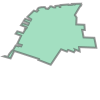

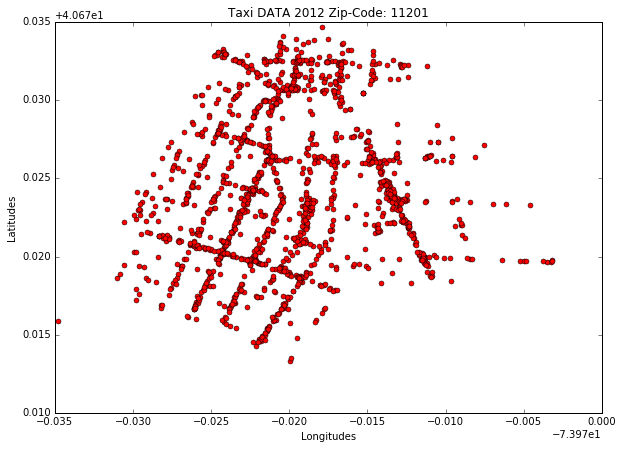

In [205]:
Plot_11201_12 = Back_Forth_BK_12[Back_Forth_BK_12.geometry.within(BK.geometry[17])]
#BK.geometry[13]
Plot_11201_12.plot(marker='o', color='red', markersize=5, figsize=(14,7))
plt.title("Taxi DATA 2012 Zip-Code: " + str(BK.postalCode.iloc[17]))
plt.xlabel("Longitudes")
plt.ylabel("Latitudes")
BK.geometry[17]

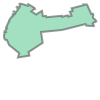

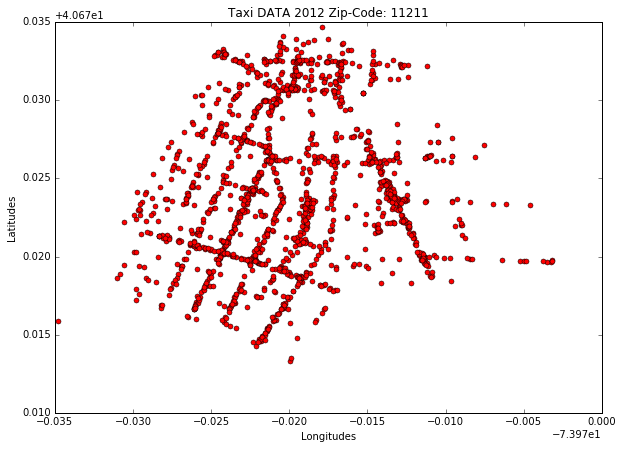

In [206]:
Plot_11211_12 = Back_Forth_BK_12[Back_Forth_BK_12.geometry.within(BK.geometry[13])]
#BK.geometry[13]
Plot_11201_12.plot(marker='o', color='red', markersize=5, figsize=(14,7))
plt.title("Taxi DATA 2012 Zip-Code: " + str(BK.postalCode.iloc[13]))
plt.xlabel("Longitudes")
plt.ylabel("Latitudes")
BK.geometry[13]

In [207]:
def heatmap(d, bins=(100,100), smoothing=1.3, cmap='jet'):
    def getx(pt):
        return pt.coords[0][0]

    def gety(pt):
        return pt.coords[0][1]

    x = list(d.geometry.apply(getx))
    y = list(d.geometry.apply(gety))
    heatmap, xedges, yedges = np.histogram2d(y, x, bins=bins)
    extent = [yedges[0], yedges[-1], xedges[-1], xedges[0]]

    logheatmap = np.log(heatmap)
    logheatmap[np.isneginf(logheatmap)] = 0
    logheatmap = ndimage.filters.gaussian_filter(logheatmap, smoothing, mode='nearest')
    
    plt.imshow(logheatmap, cmap=cmap, extent=extent)
    plt.colorbar()
    plt.gca().invert_yaxis()
    plt.show()

In [208]:
from scipy import ndimage
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
pylab.rcParams['figure.figsize'] = 14, 7

In [209]:
len(Plot_11201_12.index)

1571

In [210]:
array_idx2 = np.array(Plot_11201_12.index)
williB_12 = Taxi_Data_12.iloc[array_idx2]
array_idxh2 = np.array(Plot_11211_12.index)
BkHeight_12 = Taxi_Data_12.iloc[array_idxh2]
print(williB_12.shape)
williB_12.head()

(1571, 8)


,dropoff_latitude,dropoff_longitude,dropoff_datetime,pickup_datetime,pickup_latitude,pickup_longitude,tip_amount,trip_distance
154,40.697520,-73.988707,2012-06-30T19:21:00.000,2012-06-30T19:16:00.000,40.690595,-73.994153,1.06,0.80
455,40.634312,-74.036630,2012-08-26T22:10:00.000,2012-08-26T21:56:00.000,40.691007,-73.997895,3.95,6.07
550,40.744582,-73.983217,2012-08-30T08:19:00.000,2012-08-30T08:01:00.000,40.696182,-73.995408,0.00,4.59
568,40.759247,-73.969218,2012-09-25T14:36:00.000,2012-09-25T14:08:00.000,40.697082,-73.991687,6.00,7.59
676,40.763975,-73.958742,2012-02-04T19:20:00.000,2012-02-04T19:01:00.000,40.690937,-73.993950,3.94,7.80


In [211]:
avg_tip_williB_12   = williB_12.tip_amount[:].mean()
avg_tip_BkHeight_12 = BkHeight_12.tip_amount[:].mean()
print(avg_tip_williB_12)
print(avg_tip_BkHeight_12)

1.6842138765117753
1.5155968169761274


In [212]:
williB_12.dropoff_datetime = williB_12.dropoff_datetime.astype("datetime64")
BkHeight_12.dropoff_datetime = BkHeight_12.dropoff_datetime.astype("datetime64")

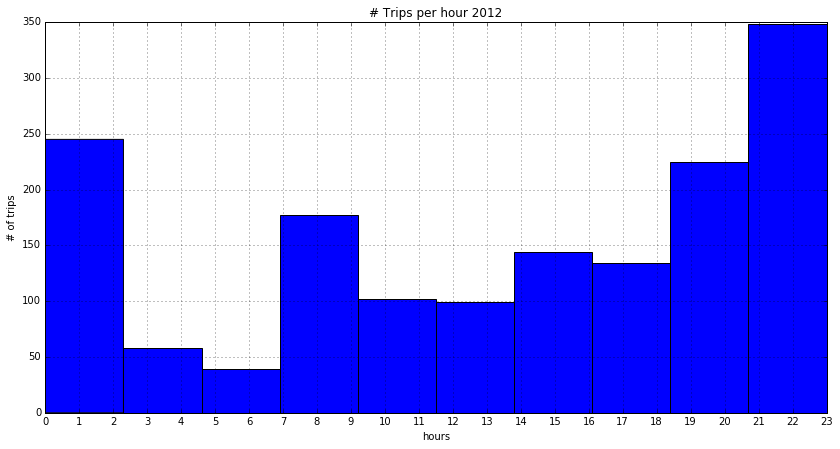

In [213]:
plt.figure(figsize=(14,7))
plt.hist(williB_12.dropoff_datetime.dt.hour)
plt.title('# Trips per hour 2012')
plt.xlabel('hours')
plt.ylabel('# of trips')
plt.grid(True)
plt.xticks(range(24))
plt.xlim(0.0,23)
plt.show()

Just like in 2014, most trips were made to or made form Brookyln-Heights (11201) within *8:15 pm (13.45 hours) to 2:00 am (2.00 hours)*

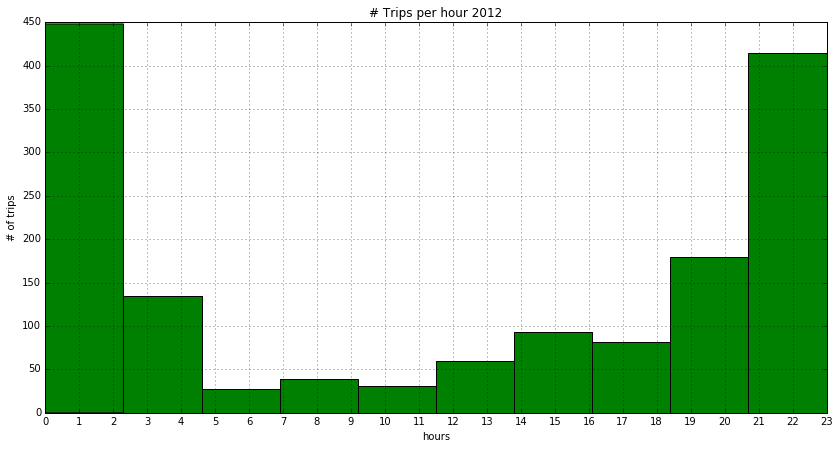

In [214]:
plt.figure(figsize=(14,7))
plt.hist(BkHeight_12.dropoff_datetime.dt.hour, color ='g')
plt.title('# Trips per hour 2012')
plt.xlabel('hours')
plt.ylabel('# of trips')
plt.grid(True)
plt.xticks(range(24))
plt.xlim(0.0,23)
plt.show()

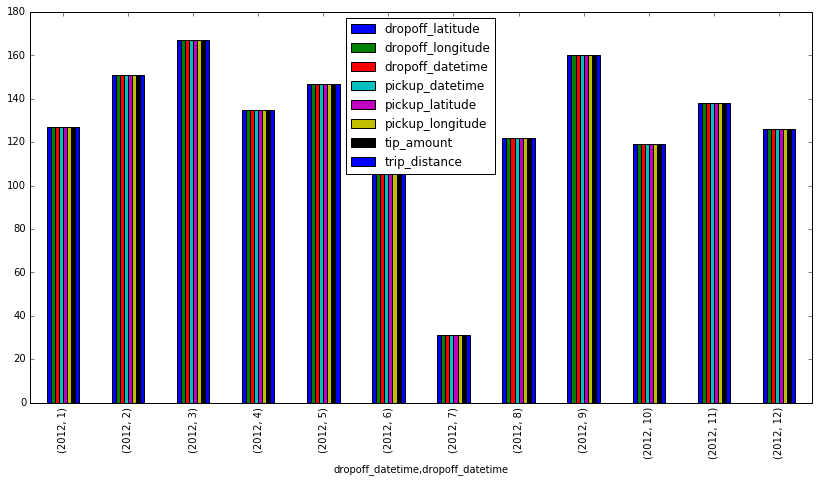

In [215]:
williB_12.groupby([williB_12.dropoff_datetime.dt.year, williB_12.dropoff_datetime.dt.month]).count().plot(kind="bar",figsize=(14,7))

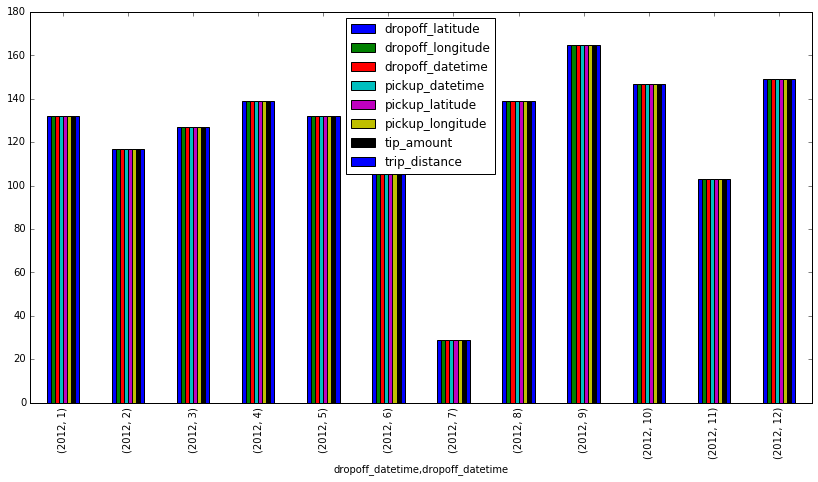

In [216]:
BkHeight_12.groupby([BkHeight_12.dropoff_datetime.dt.year, BkHeight_12.dropoff_datetime.dt.month]).count().plot(kind="bar",figsize=(14,7))


In [217]:
YTD_11_CC  = 'https://data.cityofnewyork.us/resource/uwyp-dntv.json?vendorid=VTS&payment_type=CRD&$limit=50000'
YTD_11_CSH = 'https://data.cityofnewyork.us/resource/uwyp-dntv.json?vendorid=VTS&payment_type=CSH&$limit=50000'
raw_data_Y11CC  = pd.read_json(YTD_11_CC)   #50,000 rows
raw_data_Y11CS  = pd.read_json(YTD_11_CSH) #50,000 rows
raw_data_Y11    = raw_data_Y11CC.append(raw_data_Y11CS)
raw_data_Y11.shape #100,000


(100000, 19)

In [218]:
Y_M_11 = match_col_l1(raw_data_Y11)
Y_M_11.columns.values

array(['dropoff_datetime', 'dropoff_latitude', 'dropoff_location',
       'dropoff_longitude', 'extra', 'fare_amount', 'mta_tax',
       'passenger_count', 'payment_type', 'pickup_latitude',
       'pickup_location', 'pickup_longitude', 'ratecodeid', 'tip_amount',
       'tolls_amount', 'total_amount', 'pickup_datetime', 'trip_distance',
       'vendorid'], dtype=object)

In [219]:
Taxi_Data_11 = needed_col(Y_M_11)
Taxi_Data_11.shape

(100000, 8)

In [220]:
GeoPickup_BK_11  = cov_latlon_POINT(Taxi_Data_11)
GeoDropoff_BK_11 = cov_latlon_dropoff_POINT(Taxi_Data_11)
Back_Forth_BK_11 = GeoPickup_BK_11.append(GeoDropoff_BK_11)
print(Back_Forth_BK_11.shape)
Back_Forth_BK_11.head()

(200000, 1)


,geometry
0,POINT (-73.97099799999999 40.755732)
1,POINT (-74.00928500000001 40.704272)
2,POINT (-74.00810799999999 40.722495)
3,POINT (-73.99006199999999 40.762522)
4,POINT (-73.994125 40.735057)


In [221]:
BK_only_11 = City_only_Points(GeoPickup_BK_11)

In [222]:
sum_  = 0
for i in range (len(BK_only_11)):
    sum_ = sum_ + len(BK_only_11[i])
print("Total number of Trips in BK out of 100,000 Trips for Year 2011: ", sum_)

Total number of Trips in BK out of 100,000 Trips for Year 2011:  2118


In [223]:
BK_per_Zip_11 = {}
for i in range(len(BK_only_11)):
    BK_per_Zip_11[i] = len(BK_only_11[i])

In [224]:
BK_per_Zip_df_11 = pd.DataFrame.from_dict(BK_per_Zip_11, orient='index')

In [225]:
BK_per_Zip_df_11.rename(columns={0: "Num_Trips_per_Zip_in_BK_2011"}, inplace = True)
BK_per_Zip_df_11['ZIP'] = BK.postalCode.values
BK_per_Zip_df_11.head()

,Num_Trips_per_Zip_in_BK_2011,ZIP
0,8,11221
1,14,11216
2,6,11233
3,3,11213
4,1,11212


In [226]:
max_trip = BK_per_Zip_df_11.sort_values("Num_Trips_per_Zip_in_BK_2011", ascending = False)
max_trip.head()

,Num_Trips_per_Zip_in_BK_2011,ZIP
17,614,11201
13,548,11211
23,206,11231
21,168,11217
24,110,11215


In [227]:
max_val = max_trip.reset_index()
print ("The max trips made per is Zip-Code is: ", max_val.loc[0]['Num_Trips_per_Zip_in_BK_2011'])
print ("The ZipCode that it Corresponds to is: ", max_val.loc[0].ZIP)

The max trips made per is Zip-Code is:  614
The ZipCode that it Corresponds to is:  11201


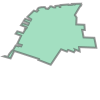

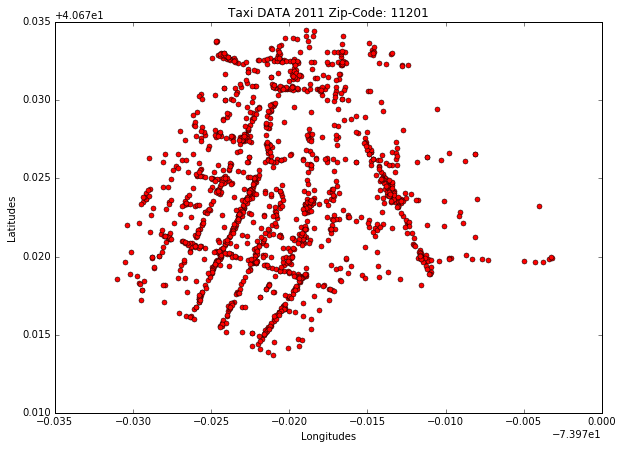

In [228]:
Plot_11201_11 = Back_Forth_BK_11[Back_Forth_BK_11.geometry.within(BK.geometry[17])]
#BK.geometry[13]
Plot_11201_11.plot(marker='o', color='red', markersize=5, figsize=(14,7))
plt.title("Taxi DATA 2011 Zip-Code: " + str(BK.postalCode.iloc[17]))
plt.xlabel("Longitudes")
plt.ylabel("Latitudes")
BK.geometry[17]

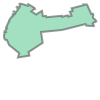

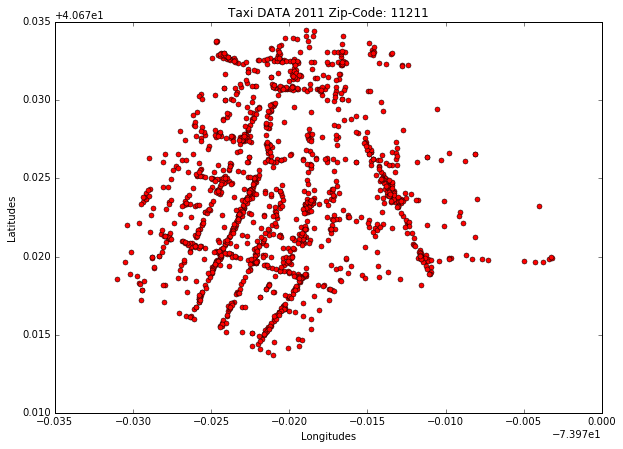

In [229]:
Plot_11211_11 = Back_Forth_BK_11[Back_Forth_BK_11.geometry.within(BK.geometry[13])]
#BK.geometry[13]
Plot_11201_11.plot(marker='o', color='red', markersize=5, figsize=(14,7))
plt.title("Taxi DATA 2011 Zip-Code: " + str(BK.postalCode.iloc[13]))
plt.xlabel("Longitudes")
plt.ylabel("Latitudes")
BK.geometry[13]

In [230]:
array_idx3  = np.array(Plot_11201_11.index)
array_idxh3 = np.array(Plot_11211_11.index)
williB_11   = Taxi_Data_11.iloc[array_idx3]
Bkheight_11 = Taxi_Data_11.iloc[array_idxh3]
williB_11.head()

,dropoff_latitude,dropoff_longitude,dropoff_datetime,pickup_datetime,pickup_latitude,pickup_longitude,tip_amount,trip_distance
187,40.815990,-73.958722,2011-10-02T11:04:00.000,2011-10-02T10:35:00.000,40.694273,-73.992518,5.94,12.15
226,40.738350,-74.006600,2011-11-12T21:04:00.000,2011-11-12T20:44:00.000,40.686567,-73.990472,3.65,4.69
233,40.780960,-73.949068,2011-01-05T22:35:00.000,2011-01-05T22:13:00.000,40.690782,-73.994102,3.00,8.97
668,40.760225,-73.981543,2011-05-01T20:50:00.000,2011-05-01T20:30:00.000,40.699712,-73.990973,3.50,5.57
704,40.689695,-73.992102,2011-10-25T22:46:00.000,2011-10-25T22:46:00.000,40.689687,-73.992105,0.00,0.00


In [231]:
avg_tip_williB_11 = williB_11.tip_amount[:].mean()
avg_Bkheight_11   = Bkheight_11.tip_amount[:].mean()
avg_tip_williB_11

1.6238766832034017

In [232]:
williB_11.dropoff_datetime   = williB_11.dropoff_datetime.astype("datetime64")
Bkheight_11.dropoff_datetime = Bkheight_11.dropoff_datetime.astype("datetime64")

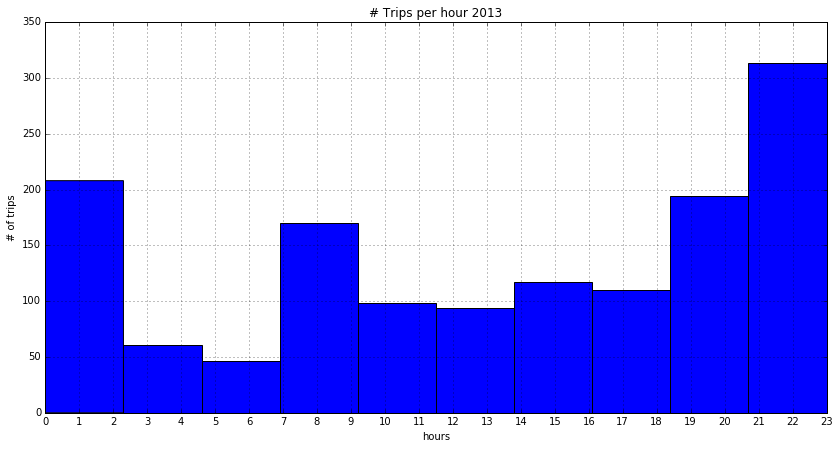

In [233]:
plt.figure(figsize=(14,7))
plt.hist(williB_11.dropoff_datetime.dt.hour)
plt.title('# Trips per hour 2013')
plt.xlabel('hours')
plt.grid(True)
plt.ylabel('# of trips')
plt.xticks(range(24))
plt.xlim(0.0,23)
plt.show()

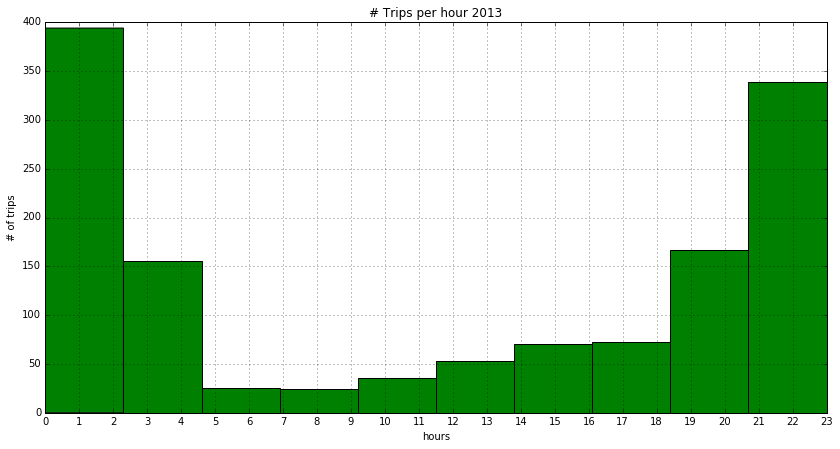

In [234]:
plt.figure(figsize=(14,7))
plt.hist(Bkheight_11.dropoff_datetime.dt.hour, color = 'green')
plt.title('# Trips per hour 2013')
plt.xlabel('hours')
plt.ylabel('# of trips')
plt.grid(True)
plt.xticks(range(24))
plt.xlim(0.0,23)
plt.show()

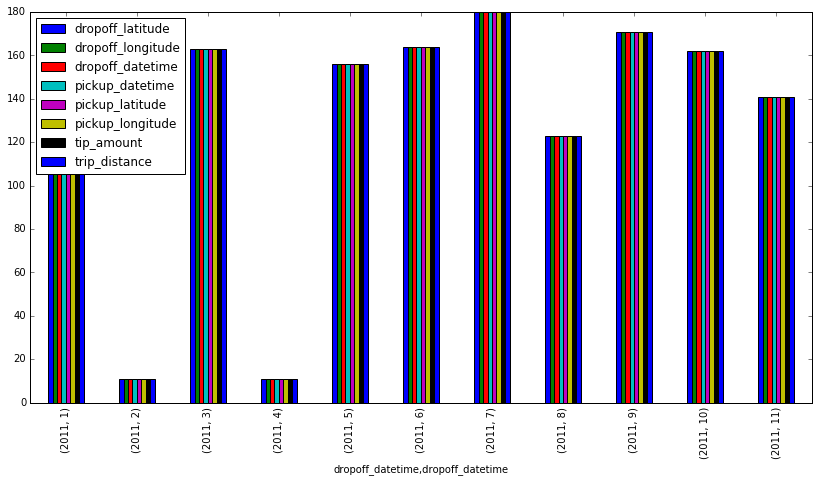

In [235]:
williB_11.groupby([williB_11.dropoff_datetime.dt.year, williB_11.dropoff_datetime.dt.month]).count().plot(kind="bar",figsize=(14,7))

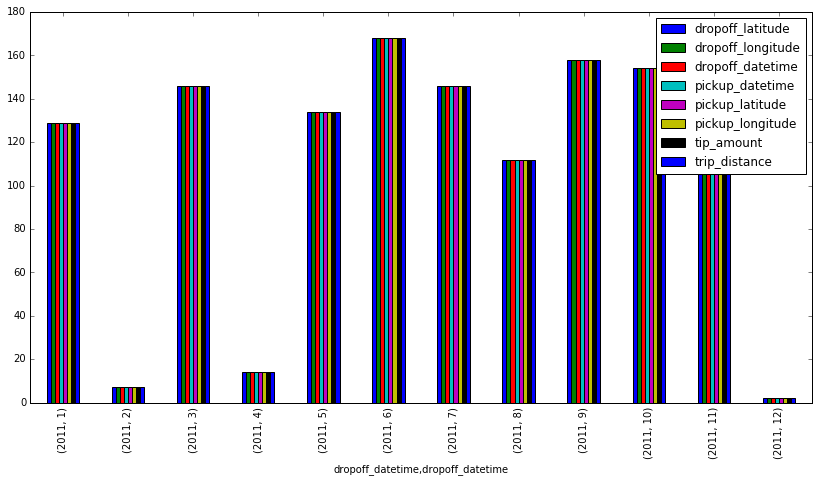

In [236]:
Bkheight_11.groupby([Bkheight_11.dropoff_datetime.dt.year, Bkheight_11.dropoff_datetime.dt.month]).count().plot(kind="bar",figsize=(14,7))

In [237]:
YTD_10_CC    = 'https://data.cityofnewyork.us/resource/74wj-s5ij.json?vendorid=VTS&payment_type=CRD&$limit=50000'
YTD_10_CSH   = 'https://data.cityofnewyork.us/resource/74wj-s5ij.json?vendorid=VTS&payment_type=CSH&$limit=50000'
raw_data_Y10CC  = pd.read_json(YTD_10_CC)   #50,000 rows
raw_data_Y10CS  = pd.read_json(YTD_10_CSH) #50,000 rows
raw_data_Y10    = raw_data_Y10CC.append(raw_data_Y10CS)
raw_data_Y10.shape #100,000



(100000, 19)

In [238]:
Y_M_10 = match_col_l1(raw_data_Y10)
Y_M_10.columns.values

array(['dropoff_datetime', 'dropoff_latitude', 'dropoff_location',
       'dropoff_longitude', 'extra', 'fare_amount', 'mta_tax',
       'passenger_count', 'payment_type', 'pickup_latitude',
       'pickup_location', 'pickup_longitude', 'ratecodeid', 'tip_amount',
       'tolls_amount', 'total_amount', 'pickup_datetime', 'trip_distance',
       'vendorid'], dtype=object)

In [239]:
Taxi_Data_10 = needed_col(Y_M_10)
Taxi_Data_10.shape

(100000, 8)

In [240]:
GeoPickup_BK_10  = cov_latlon_POINT(Taxi_Data_10)
GeoDropoff_BK_10 = cov_latlon_dropoff_POINT(Taxi_Data_10)
Back_Forth_BK_10 = GeoPickup_BK_10.append(GeoDropoff_BK_10)
print(Back_Forth_BK_10.shape)
Back_Forth_BK_10.head()

(200000, 1)


,geometry
0,POINT (-73.988743 40.777922)
1,POINT (-73.976523 40.748023)
2,POINT (-73.97625499999999 40.765907)
3,POINT (-73.99166 40.726313)
4,POINT (-73.965318 40.759405)


In [241]:
BK_only_10 = City_only_Points(Back_Forth_BK_10)

In [242]:
sum_  = 0
for i in range (len(BK_only_10)):
    sum_ = sum_ + len(BK_only_10[i])
print("Total number of Trips in BK out of 100,000 Trips for Year 2010: ", sum_)

Total number of Trips in BK out of 100,000 Trips for Year 2010:  6268


In [243]:
BK_per_Zip_10 = {}
for i in range(len(BK_only_10)):
    BK_per_Zip_10[i] = len(BK_only_10[i])

In [244]:
BK_per_Zip_df_10 = pd.DataFrame.from_dict(BK_per_Zip_10, orient='index')

In [245]:
BK_per_Zip_df_10.rename(columns={0: "Num_Trips_per_Zip_in_BK_2010"}, inplace = True)
BK_per_Zip_df_10['ZIP'] = BK.postalCode.values
BK_per_Zip_df_10.head()

,Num_Trips_per_Zip_in_BK_2010,ZIP
0,83,11221
1,103,11216
2,25,11233
3,33,11213
4,18,11212


In [246]:
max_trip = BK_per_Zip_df_10.sort_values("Num_Trips_per_Zip_in_BK_2010", ascending = False)
max_trip.head()

,Num_Trips_per_Zip_in_BK_2010,ZIP
17,1389,11201
13,1119,11211
24,448,11215
21,447,11217
12,439,11222


In [247]:
max_val = max_trip.reset_index()
print ("The max trips made per is Zip-Code is: ", max_val.loc[0]['Num_Trips_per_Zip_in_BK_2010'])
print ("The ZipCode that it Corresponds to is: ", max_val.loc[0].ZIP)

The max trips made per is Zip-Code is:  1389
The ZipCode that it Corresponds to is:  11201


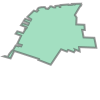

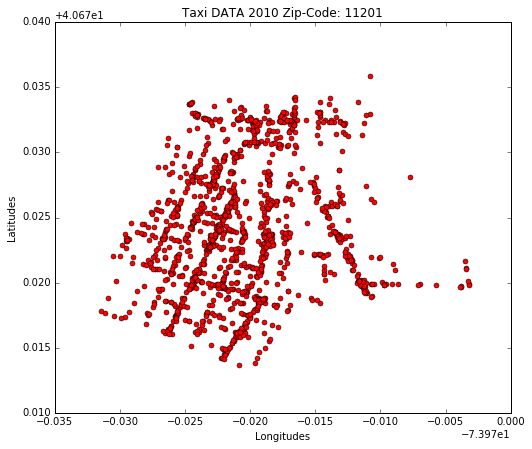

In [248]:
Plot_11201_10 = Back_Forth_BK_10[Back_Forth_BK_10.geometry.within(BK.geometry[17])]
#BK.geometry[13]
Plot_11201_10.plot(marker='o', color='red', markersize=5, figsize=(14,7))
plt.title("Taxi DATA 2010 Zip-Code: " + str(BK.postalCode.iloc[17]))
plt.xlabel("Longitudes")
plt.ylabel("Latitudes")
BK.geometry[17]

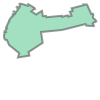

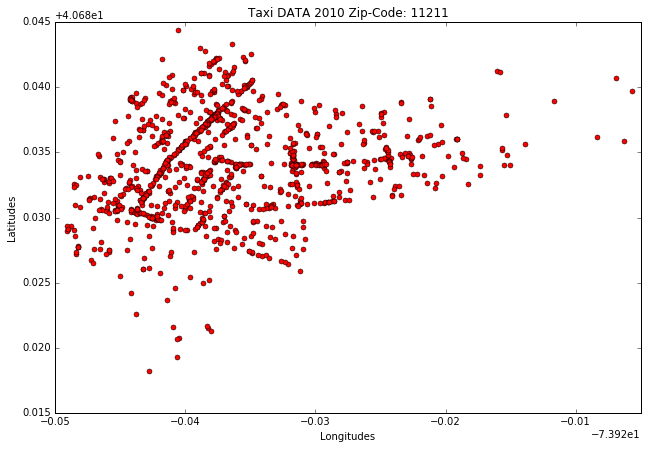

In [249]:
Plot_11211_10 = Back_Forth_BK_10[Back_Forth_BK_10.geometry.within(BK.geometry[13])]
#BK.geometry[13]
Plot_11211_10.plot(marker='o', color='red', markersize=5, figsize=(14,7))
plt.title("Taxi DATA 2010 Zip-Code: " + str(BK.postalCode.iloc[13]))
plt.xlabel("Longitudes")
plt.ylabel("Latitudes")
BK.geometry[13]

In [250]:
array_idx4 = np.array(Plot_11201_10.index)
williB_10 = Taxi_Data_12.iloc[array_idx4]
array_idxh4 = np.array(Plot_11211_10.index)
BkHeight_10 = Taxi_Data_12.iloc[array_idxh4]
williB_10.head()

,dropoff_latitude,dropoff_longitude,dropoff_datetime,pickup_datetime,pickup_latitude,pickup_longitude,tip_amount,trip_distance
27,40.726252,-74.001448,2012-11-12T20:31:00.000,2012-11-12T20:21:00.000,40.741017,-74.007467,1.70,1.32
422,40.770873,-73.958988,2012-04-27T16:58:00.000,2012-04-27T16:49:00.000,40.771848,-73.982077,2.08,1.66
594,40.741462,-74.001315,2012-10-19T11:04:00.000,2012-10-19T10:51:00.000,40.722847,-74.005055,1.90,1.40
795,40.731532,-73.999215,2012-03-09T12:26:00.000,2012-03-09T12:21:00.000,40.731522,-73.988567,1.00,0.74
884,40.766900,-73.982248,2012-09-29T20:42:00.000,2012-09-29T20:38:00.000,40.777592,-73.978778,2.00,0.93


In [251]:
avg_tip_williB_10    = williB_10.tip_amount[:].mean()
avg_tip_BkHeight_10 = BkHeight_10.tip_amount[:].mean()
print(avg_tip_BkHeight_10)
print(avg_tip_williB_10)

1.177345844504023
1.2352915766738661


In [256]:
williB_10.dropoff_datetime = williB_10.dropoff_datetime.astype("datetime64")
BkHeight_10.dropoff_datetime = BkHeight_10.dropoff_datetime.astype("datetime64")

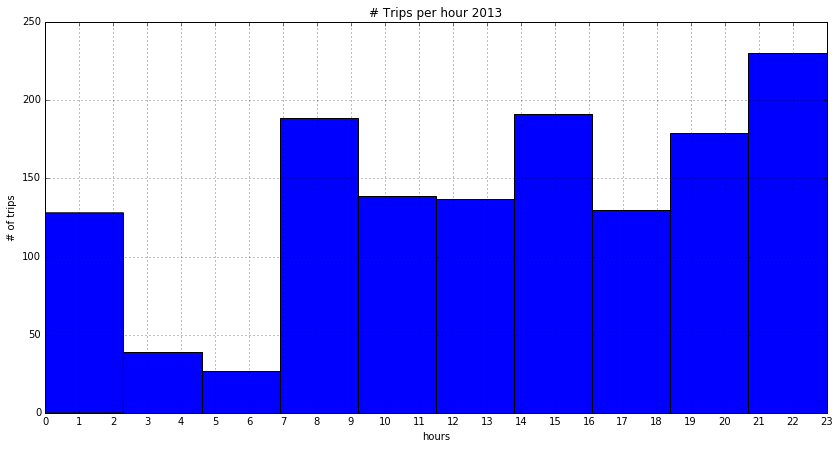

In [257]:
plt.figure(figsize=(14,7))
plt.hist(williB_10.dropoff_datetime.dt.hour)
plt.title('# Trips per hour 2013')
plt.xlabel('hours')
plt.ylabel('# of trips')
plt.grid(True)
plt.xticks(range(24))
plt.xlim(0.0,23)
plt.show()

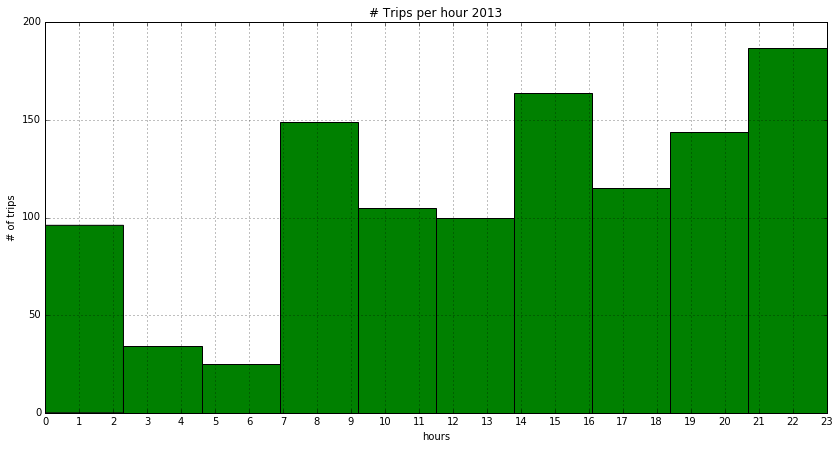

In [258]:
plt.figure(figsize=(14,7))
plt.hist(BkHeight_10.dropoff_datetime.dt.hour, color ='g')
plt.title('# Trips per hour 2013')
plt.xlabel('hours')
plt.ylabel('# of trips')
plt.grid(True)
plt.xticks(range(24))
plt.xlim(0.0,23)
plt.show()

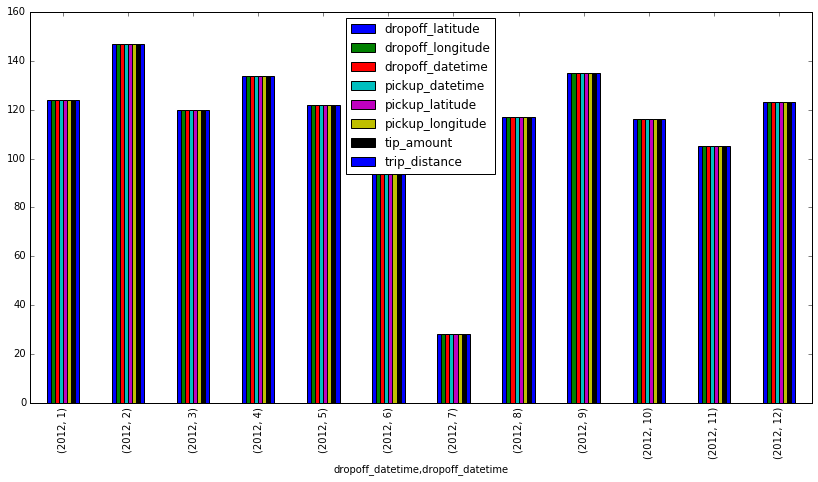

In [259]:
williB_10.groupby([williB_10.dropoff_datetime.dt.year, williB_10.dropoff_datetime.dt.month]).count().plot(kind="bar",figsize=(14,7))

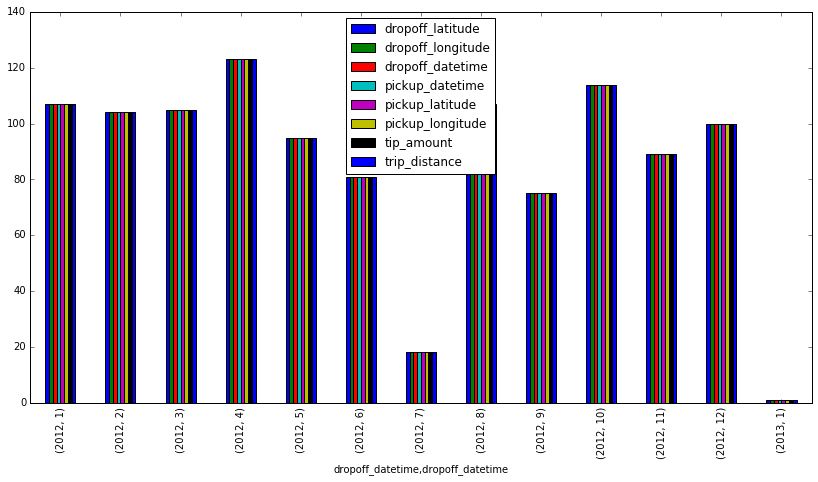

In [260]:
BkHeight_10.groupby([BkHeight_10.dropoff_datetime.dt.year, BkHeight_10.dropoff_datetime.dt.month]).count().plot(kind="bar",figsize=(14,7))

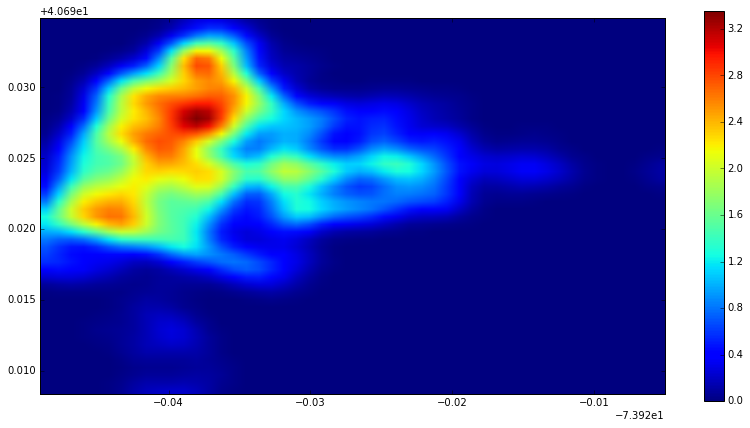

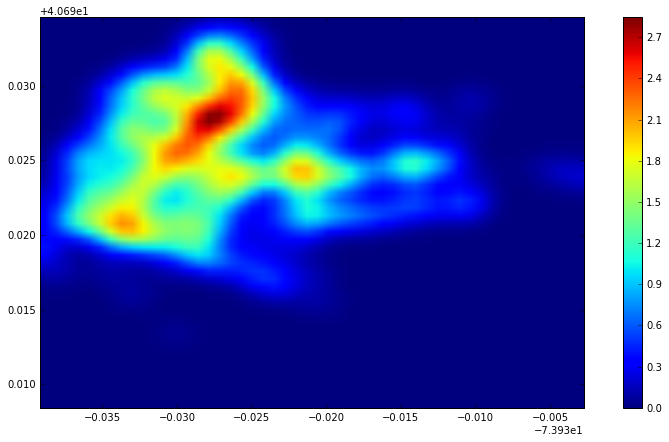

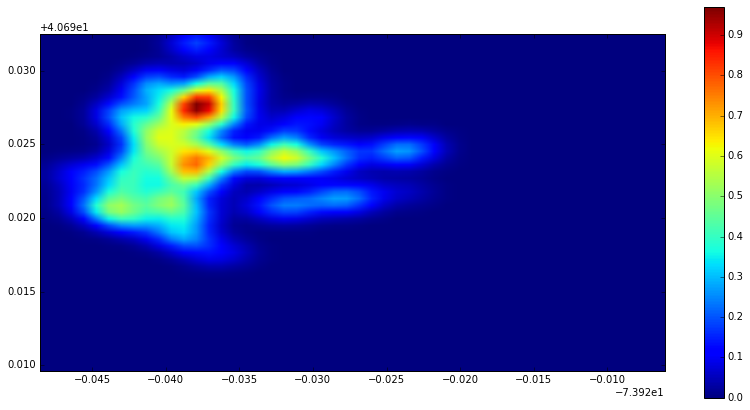

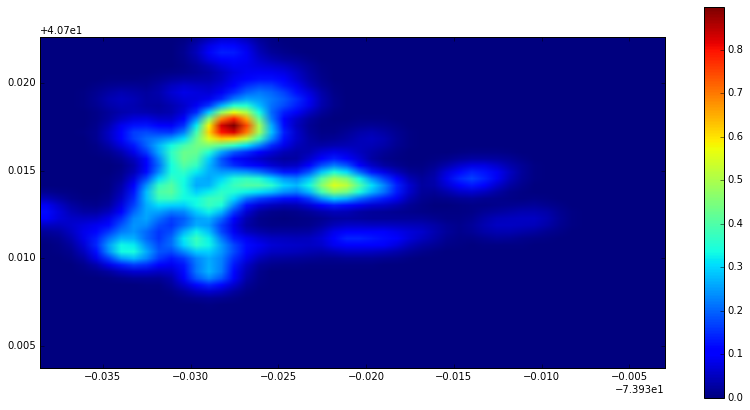

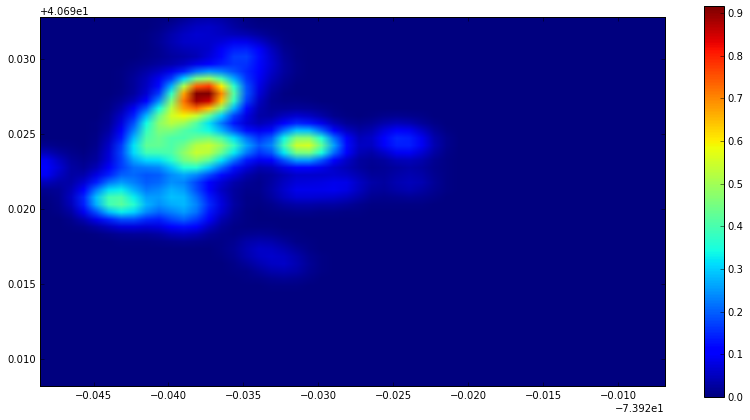

In [261]:
heatmap(GeoPickup_BK[GeoPickup_BK.geometry.within(BK.geometry[13])].convex_hull, bins=50, smoothing=1.5)
heatmap(GeoPickup_BK_13[GeoPickup_BK_13.geometry.within(BK.geometry[13])].convex_hull, bins=50, smoothing=1.5)
heatmap(GeoPickup_BK_12[GeoPickup_BK_12.geometry.within(BK.geometry[13])].convex_hull, bins=50, smoothing=1.5)
heatmap(GeoPickup_BK_11[GeoPickup_BK_11.geometry.within(BK.geometry[13])].convex_hull, bins=50, smoothing=1.5)
heatmap(GeoPickup_BK_10[GeoPickup_BK_10.geometry.within(BK.geometry[13])].convex_hull, bins=50, smoothing=1.5)

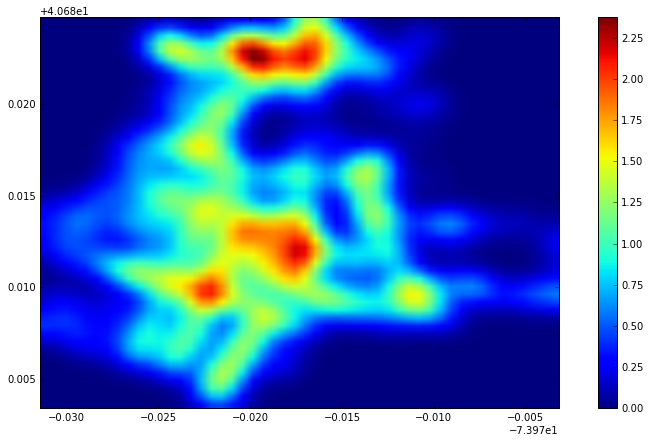

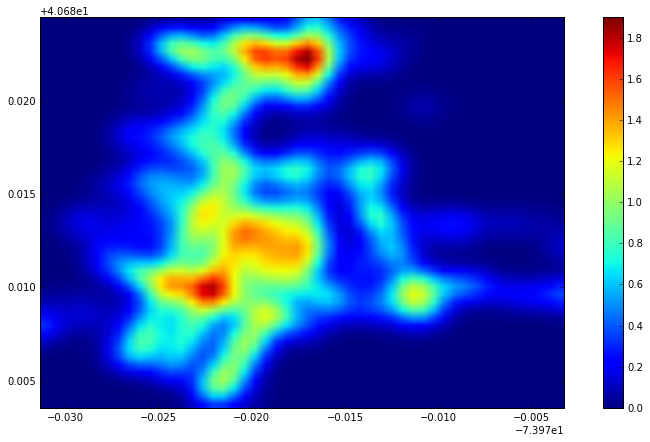

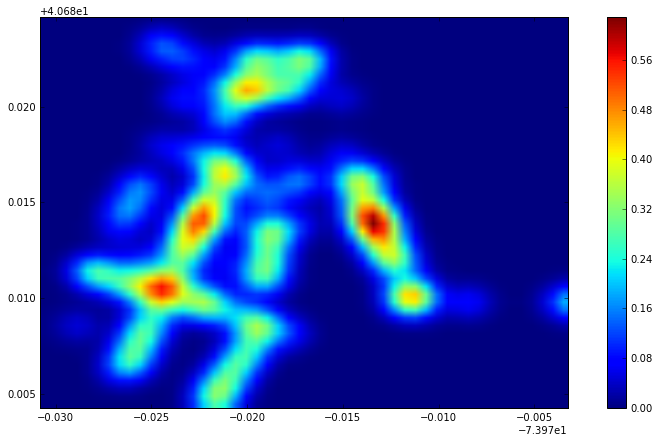

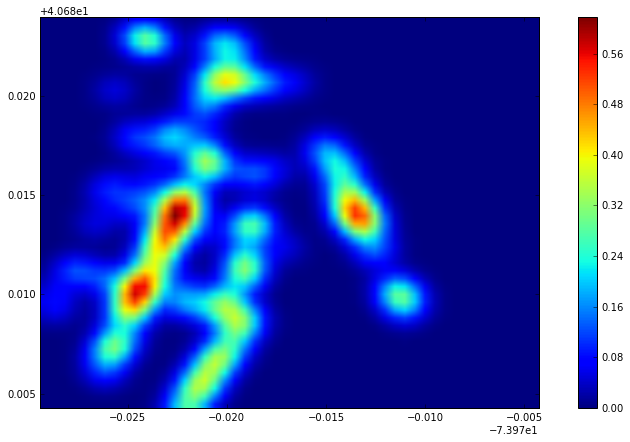

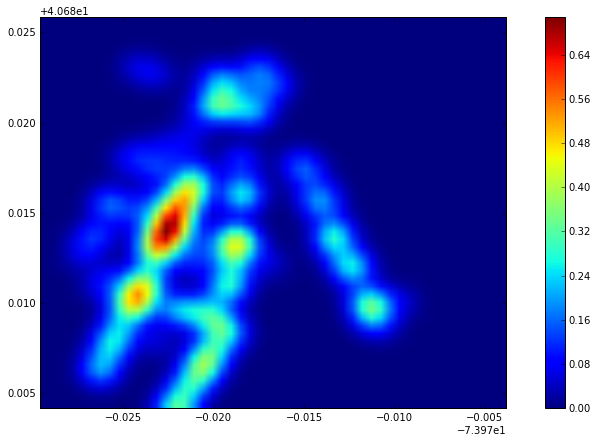

In [262]:
heatmap(GeoPickup_BK[GeoPickup_BK.geometry.within(BK.geometry[17])].convex_hull, bins=50, smoothing=1.5)
heatmap(GeoPickup_BK_13[GeoPickup_BK_13.geometry.within(BK.geometry[17])].convex_hull, bins=50, smoothing=1.5)
heatmap(GeoPickup_BK_12[GeoPickup_BK_12.geometry.within(BK.geometry[17])].convex_hull, bins=50, smoothing=1.5)
heatmap(GeoPickup_BK_11[GeoPickup_BK_11.geometry.within(BK.geometry[17])].convex_hull, bins=50, smoothing=1.5)
heatmap(GeoPickup_BK_10[GeoPickup_BK_10.geometry.within(BK.geometry[17])].convex_hull, bins=50, smoothing=1.5)

In [263]:
Williamsburg_1 = williB.append(williB_13)
Williamsburg_2 = Williamsburg_1.append(williB_12)
Williamsburg_3 = Williamsburg_2.append(williB_11)
Williamsburg_4 = Williamsburg_3.append(williB_10)

In [264]:
train_dist = np.array(Williamsburg_4.trip_distance.values)
train_dist = train_dist[:20740]

In [266]:
BrookylnHeights_1 = BkHeight.append(BkHeight_13)
BrookylnHeights_2 = BrookylnHeights_1.append(BkHeight_12)
BrookylnHeights_3 = BrookylnHeights_2.append(Bkheight_11)
BrookylnHeights_4 = BrookylnHeights_3.append(BkHeight_10)

In [267]:
test_dist = np.array(BrookylnHeights_4.trip_distance.values)

/home/cherno/.local/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



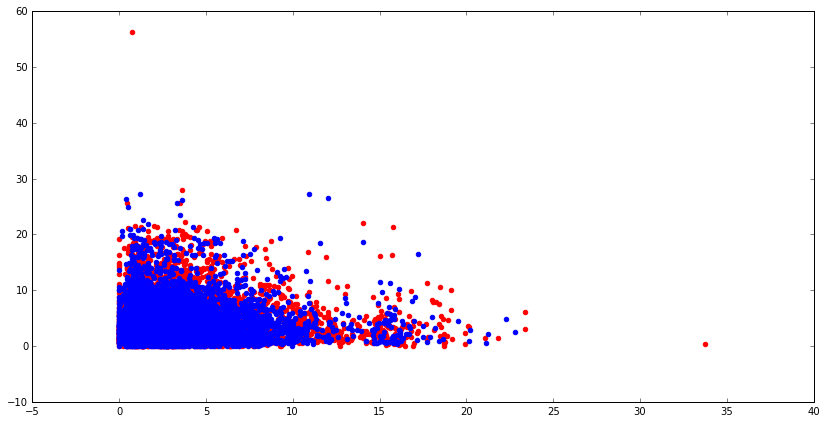

In [268]:
from sklearn.cross_validation import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(train_dist, test_dist, train_size=0.6)
plt.scatter(xtrain, ytrain, color='red')
plt.scatter(xtest, ytest, color='blue')